<a href="https://colab.research.google.com/github/RonakMehta21/CMPE-258-DL/blob/master/Implement_MNIST_Classifier_using_NumPy_without_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement MNIST Classifier using NumPy without CNN

### Download the MNIST dataset

In [0]:
# Import the necessary libraries 
import sys, numpy as np
from keras.datasets import mnist
%matplotlib inline
import matplotlib.pyplot as plt

### Load the Dataset

In [0]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

The dataset has a training set of `60,000` examples and test set of `10,000` examples.

In [12]:
print("Training examples: ",x_train.shape)
print("Test examples: ",x_test.shape)

Training examples:  (60000, 28, 28)
Test examples:  (10000, 28, 28)


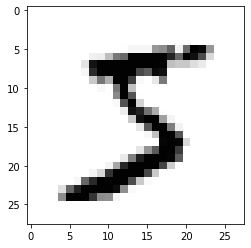

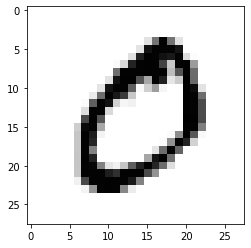

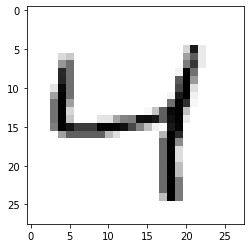

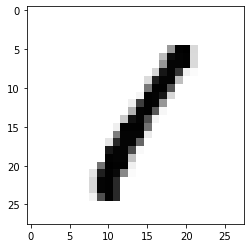

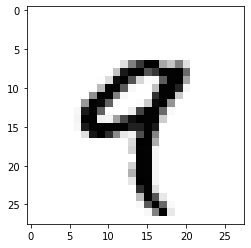

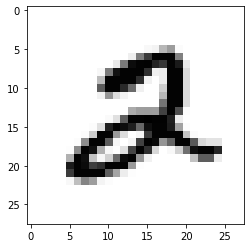

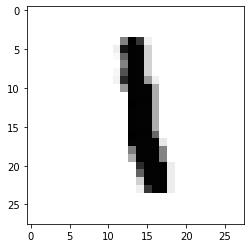

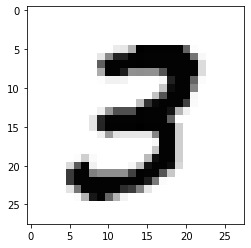

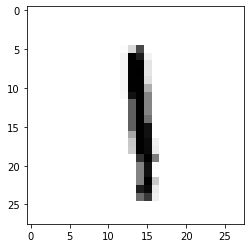

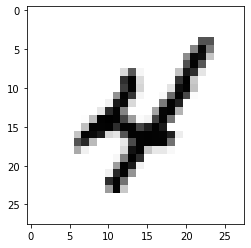

In [13]:
# Before preprocessing the dataset with feed-forward neural network, checking the data
for i in range(10):
    img = np.asfarray(x_train)[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

### Preprocess the Dataset

Image Augmentation using Keras

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# reshape to be [samples][width][height][channels]
X_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
X_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

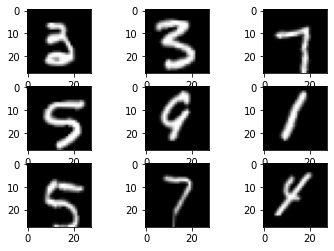

In [15]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

*Scaling the Input*: The images of the MNIST dataset are greyscale and the pixels range between 0 and 255. We will map these values into an interval from [0, 1] by dividing the values by 255.

In [0]:
images,labels = (X_train.reshape(len(X_train),28*28)/255,y_train)
one_hot_labels = np.zeros((len(labels),10))

The labels, `y_train` and `y_test` contain numbers of no specific preference. The data in the column denotes a value or a category. In order to not confuse the machine learning model. The labels have to be **One Hot Encoded**.

In [0]:
for i,l in enumerate(labels):
  one_hot_labels[i][l] = 1
labels = one_hot_labels

In [0]:
test_images = X_test.reshape(len(X_test),28*28)/255
test_labels = np.zeros((len(y_test),10))
for i,l in enumerate(y_test):
  test_labels[i][l]=1

### Define the network Architecture 

In [0]:
np.random.seed(1)
batch_size = 100
##Defining different activation functions and their derivatives
def tanh(x):
  return np.tanh(x)
def tanh2deriv(output):
  return 1-(output**2)
relu = lambda x:(x>=0)*x
relu2deriv = lambda x:x>=0
def softmax(x):
  temp = np.exp(x)
  return temp/np.sum(temp,axis=1,keepdims=True)
## Defining Alpha, epochs, 1st hidden layer size, Input Layer size and Output layer size values
alpha,iterations,hidden_size, pixels_per_image, num_labels = (0.01,300,300,784,10)
## Initialize with random weights
weights_0_1 = np.random.randn(pixels_per_image,hidden_size)*np.sqrt(2.0/hidden_size)
weights_1_2 = np.random.randn(hidden_size,100)*np.sqrt(2.0/100)
weights_2_3 = np.random.randn(100,num_labels)*np.sqrt(2.0/num_labels)

### Run the model with 2 hidden layers and one output layer

In [23]:
for j in range(iterations):
  ## Initializig the error to 0
  error,correct_cnt = (0.0,0)
  for i in range(int(len(images)/batch_size)):
    batch_start, batch_end = ((i*batch_size),((i+1)*batch_size))
    layer_0 = images[batch_start:batch_end]
    layer_1 = tanh(np.dot(layer_0,weights_0_1))
    ## Dropout for 1st layer
    dropout_mask = np.random.randint(2,size=layer_1.shape)
    layer_1 *= dropout_mask*2 
    layer_2 = relu(np.dot(layer_1,weights_1_2))
    layer_3 = softmax(np.dot(layer_2,weights_2_3))
    error+=np.sum((labels[batch_start:batch_end]-layer_3)**2)
    
    for k in range(batch_size):
      correct_cnt+=int(np.argmax(layer_3[k:k+1])==np.argmax(labels[batch_start+k:batch_start+k+1]))
    layer_3_delta = (labels[batch_start:batch_end]-layer_3)/(batch_size * layer_3.shape[0])
    layer_2_delta = layer_3_delta.dot(weights_2_3.T)*relu2deriv(layer_2)
    layer_1_delta = layer_2_delta.dot(weights_1_2.T)*tanh2deriv(layer_1)
    layer_1_delta *= dropout_mask

    weights_2_3 += alpha*layer_2.T.dot(layer_3_delta)
    weights_1_2 += 0.1*layer_1.T.dot(layer_2_delta)
    weights_0_1 += 0.2*alpha*layer_0.T.dot(layer_1_delta)
  test_correct_cnt=0
  y_pred=[]
  actual_labels=[]
  for i in range(len(test_images)):
    layer_0 = test_images[i:i+1]
    layer_1 = tanh(np.dot(layer_0,weights_0_1))
    layer_2 = relu(np.dot(layer_1,weights_1_2))
    layer_3 = np.dot(layer_2,weights_2_3)
    y_pred += [int(np.argmax(layer_3))]
    actual_labels += [np.argmax(test_labels[i:i+1])]
    test_correct_cnt += int(np.argmax(layer_3)==np.argmax(test_labels[i:i+1]))
  if (j%10==0):
    sys.stdout.write("\n"+"I:"+str(j)+" Test-Acc:"+str(test_correct_cnt/float(len(test_images)))+" Train-Acc:"+'{:0.6f}'.format(correct_cnt/float(len(images))))


I:0 Test-Acc:0.6237 Train-Acc:0.389983
I:10 Test-Acc:0.8225 Train-Acc:0.710783
I:20 Test-Acc:0.8463 Train-Acc:0.752417
I:30 Test-Acc:0.8559 Train-Acc:0.766517
I:40 Test-Acc:0.8607 Train-Acc:0.776300
I:50 Test-Acc:0.8655 Train-Acc:0.783100
I:60 Test-Acc:0.8696 Train-Acc:0.786000
I:70 Test-Acc:0.8704 Train-Acc:0.786983
I:80 Test-Acc:0.8736 Train-Acc:0.786733
I:90 Test-Acc:0.8751 Train-Acc:0.793067
I:100 Test-Acc:0.8762 Train-Acc:0.794567
I:110 Test-Acc:0.878 Train-Acc:0.794250
I:120 Test-Acc:0.8782 Train-Acc:0.795217
I:130 Test-Acc:0.8804 Train-Acc:0.795833
I:140 Test-Acc:0.8811 Train-Acc:0.799867
I:150 Test-Acc:0.8818 Train-Acc:0.800550
I:160 Test-Acc:0.8825 Train-Acc:0.799283
I:170 Test-Acc:0.8831 Train-Acc:0.800400
I:180 Test-Acc:0.8844 Train-Acc:0.802717
I:190 Test-Acc:0.8862 Train-Acc:0.801417
I:200 Test-Acc:0.8865 Train-Acc:0.805267
I:210 Test-Acc:0.8874 Train-Acc:0.804250
I:220 Test-Acc:0.8881 Train-Acc:0.806500
I:230 Test-Acc:0.8889 Train-Acc:0.804817
I:240 Test-Acc:0.8893 Train

### Results

Test Accuracy of 89% and Training Accuracy of 81% with 300 epochs

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
accuracy_score(actual_labels, y_pred)*100

89.25999999999999

### Evaluate the Model using Confusion Matrix

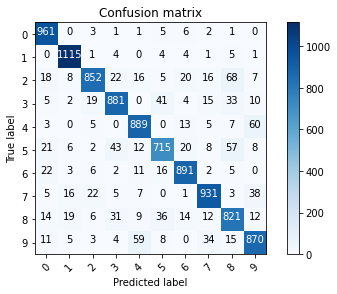

In [31]:
# Confusion matrix 
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx = confusion_matrix(actual_labels, y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))